In [1]:
import sys; sys.path.append('../rrr')
import decoy_mnist
from multilayer_perceptron import *
from figure_grid import *
from local_linear_explanation import *
import random
import numpy as np
import matplotlib.pyplot as plt

# Decoy MNIST

This is a version of MNIST augmented with color splotches that correspond to the digits in the training set but not the test set. These color splotches are a "decoy rule" the model could inappropriately learn and try to apply to the test set, similar to the Husky vs. Wolf problem in [LIME](https://arxiv.org/abs/1602.04938).

Let's see if we can fool the perceptron but then help it correct its mistake.

In [2]:
Xr, X, y, E, Xtr, Xt, yt, Et = decoy_mnist.generate_dataset(cachefile='../data/decoy-mnist.npz')
Xr = np.array([x.ravel() for x in Xr])
Xtr = np.array([x.ravel() for x in Xtr])

Let's visualize our dataset first:

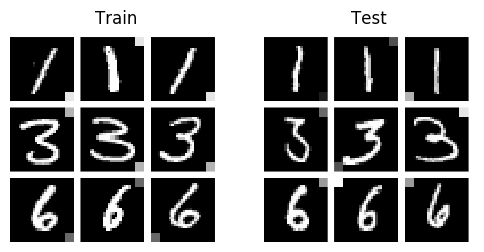

In [158]:
def examples_matching(digits, X, y):
  return X[np.array([list(np.argwhere(y==d).T[0][167:230]) for d in digits]).T.ravel()]

plt.subplot(121)
plt.title('Train')
image_grid(examples_matching([1,3,6], X, y), (28,28), 3)
plt.subplot(122)
plt.title('Test')
image_grid(examples_matching([1,3,6], Xt, yt), (28,28), 3)
plt.show()

Note that all training examples have the same splotch color for each digit, and all test examples have randomly colored splotches. We'll train three models: an MLP on the decoy set normally, an MLP on the decoy set with annotations to help it generalize, and an MLP on the actual MNIST dataset.

In [4]:
mlp_normal = MultilayerPerceptron()
mlp_normal.fit(X, y)
print(mlp_normal.score(X, y))
print(mlp_normal.score(Xt, yt))

0.996916666667
0.5155


In [5]:
mlp_annotated = MultilayerPerceptron(l2_grads=1000)
mlp_annotated.fit(X, y, E)
print(mlp_annotated.score(X, y))
print(mlp_annotated.score(Xt, yt))

0.982016666667
0.9607


In [6]:
mlp_nondecoy = MultilayerPerceptron()
mlp_nondecoy.fit(Xr, y)
print(mlp_nondecoy.score(Xtr, yt))
print(mlp_nondecoy.score(Xr, y))

0.9611
0.992233333333


In [234]:
test_scores = [mlp_normal.score(Xt, yt), mlp_annotated.score(Xt, yt), mlp_nondecoy.score(Xtr, yt)]
model_names = ['$A=0$', 'full $A$', 'Baseline']

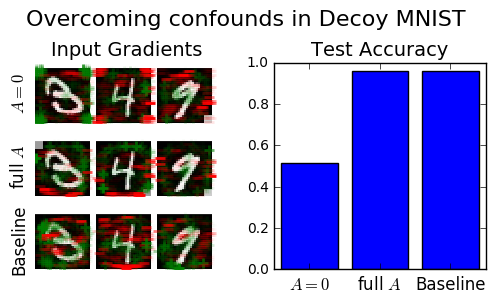

In [254]:
def explain(model, title='', length=3, i=0, Xt=Xt, **kwargs):
  if title:
    plt.title(title)
  explanation_grid(model.grad_explain(Xt[i:i+length]), (28,28), gridshape=(length,1), **kwargs)

ii=18
ss=50
gridsize = (3,2)
plt.figure(figsize=(6, 2.67))
plt.suptitle('Overcoming confounds in Decoy MNIST', y=1.1, fontsize=16)

plt.subplot2grid(gridsize, (0,0))
plt.title('Input Gradients', fontsize=14)
explain(mlp_normal, i=ii,size=ss); plt.ylabel('$A=0$', fontsize=12)

plt.subplot2grid(gridsize, (1,0))
explain(mlp_annotated, i=ii,size=ss); plt.ylabel('full $A$', fontsize=12)

plt.subplot2grid(gridsize, (2,0))
explain(mlp_nondecoy, Xt=Xtr,i=ii,size=ss); plt.ylabel('Baseline', fontsize=12)

plt.subplot2grid(gridsize, (0,1), rowspan=3)
plt.title('Test Accuracy', fontsize=14)
plt.bar(np.arange(len(test_scores))+0.1, test_scores)
plt.gca().set_xticks([0.5,1.5,2.5])
plt.gca().set_xticklabels(model_names, fontsize=12)
plt.xlim(0,3)
plt.ylim(0,1)

plt.show()

It looks like the decoy model focuses many of its input gradients on the corners, but the baseline model and the model trained to ignore the corners both achieve high test accuracy.

## Comparison with LIME

Let's see how the (newly-released) [image version of LIME](http://marcotcr.github.io/lime/tutorials/Tutorial%20-%20images.html) does compared to gradients. Let's consider the first example:

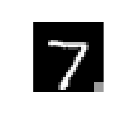

In [30]:
plt.figure(figsize=(1,1))
image_grid(Xt[:1], (28,28), 1)
plt.show()

This is an example our classifier gets confused about because of the decoy rule, as we can see from its assigned probabilities:

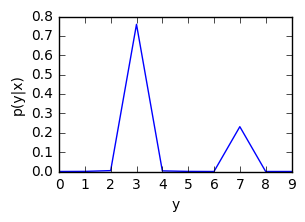

In [148]:
plt.figure(figsize=(3,2))
plt.plot(mlp_normal.predict_proba(Xt[:1])[0])
plt.xlabel('y')
plt.ylabel('p(y|x)')
plt.show()

Let's compare input gradients to LIME and see whether they agree. Note that to use LIME, as of this release, we're going to have to convert our BW image to RGB (which may change in future releases).

In [181]:
from lime import lime_image
lime_explainer = lime_image.LimeImageExplainer()

In [183]:
import time

def to_rgb(bw_image, l=28, w=28):
  result = np.zeros((l,w,3))
  for i in range(l):
    for j in range(w):
      value = bw_image.reshape((l,w))[i][j]
      for k in range(3):
        result[i][j] = 255-value
  return result

def to_bw(rgb_image, l=28, w=28):
  result = np.zeros((l,w))
  for i in range(l):
    for j in range(w):
      result[i][j] = 255-rgb_image.reshape((l,w,3))[i][j][0]
  return result.ravel()

def predict_fn_for(mlp):
  return lambda image: mlp.predict_proba(np.array([to_bw(image, 28, 28)]))

t1 = time.clock()
lime_explanation = lime_explainer.explain_instance(
  to_rgb(Xt[0]), predict_fn_for(mlp_normal), top_labels=2, hide_color=True, num_samples=1000, batch_size=1)
t2 = time.clock()

print('LIME for took {:.5f}s'.format(t2-t1))

LIME for took 2.00856s


In [184]:
t3 = time.clock()
mlp_normal.input_gradients(Xt)
t4 = time.clock()
print('gradients took {:.6f}s/example'.format((t4-t3)/len(Xt)))

gradients took 0.000049s/example


In [131]:
grad_explanation3 = LocalLinearExplanation(Xt[0], 3, mlp_normal.input_gradients(Xt[:1], y=3))
grad_explanation7 = LocalLinearExplanation(Xt[0], 7, mlp_normal.input_gradients(Xt[:1], y=7))

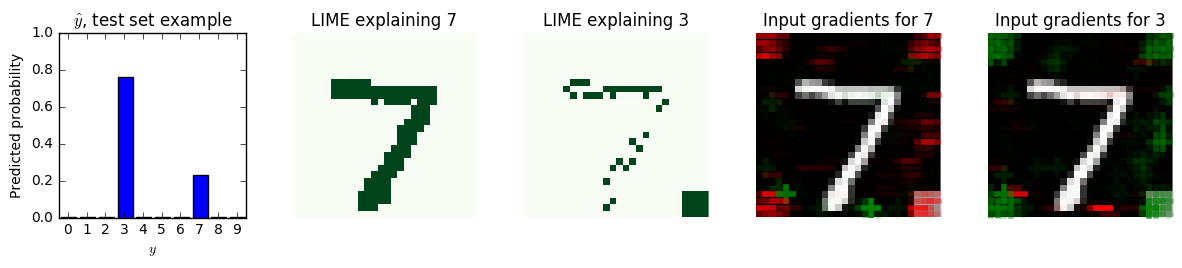

In [554]:
img7, mask7 = lime_explanation.get_image_and_mask(7)
img3, mask3 = lime_explanation.get_image_and_mask(3)

with figure_grid(1,5,rowheight=2.8) as g:
  g.next()
  plt.bar(np.arange(10)-0.35, mlp_normal.predict_proba(Xt[:1])[0])
  plt.xticks(range(10))
  plt.title(r'$\hat{y}$, test set example')
  plt.xlabel(r'$y$')
  plt.ylim(0,1)
  plt.ylabel('Predicted probability')
  plt.xlim(-0.5, 9.5)
  
  g.next()
  plt.title('LIME explaining 7')
  plt.axis('off')
  plt.imshow(255-mask7, interpolation='none', cmap='Greens')
  
  g.next()
  plt.title('LIME explaining 3')
  plt.axis('off')
  plt.imshow(255-mask3, interpolation='none', cmap='Greens')
  
  g.next()
  plt.title(r'Input gradients for 7')
  plt.xlim(0,28)
  plt.ylim(0,28)
  plt.axis('off')
  imshow_bw(grad_explanation7, (28,28), size=200, lw=4)
  
  g.next()
  plt.title(r'Input gradients for 3')
  plt.xlim(0,28)
  plt.ylim(0,28)
  plt.axis('off')
  imshow_bw(grad_explanation3, (28,28), size=200, lw=4)

LIME is only outputting masks, but we can see that for 7 it focuses on the digit, and for 3, it focuses on the decoy, which makes sense. Gradients focus on the decoy in both cases, because changing the decoy swatch in any location will have a strong effect on the outputted probability. Here we can see the major differences in the implicit counterfactuals behind LIME and gradient explanations: LIME adds or removes superpixels present in the image, so it focuses on areas in the image, while gradients can "imagine" adding elements to the image that aren't actually there. Both have strengths and weaknesses. The agreement on at least identifying the swatch shows that both methods are useful for this problem, however.

## Find-another-explanation

The training procedure is implemented in a separate script in `bin`, but let's analyze its results here:

In [9]:
import pickle
fae_1000s = [MultilayerPerceptron.from_params(p)
             for p in pickle.load(open('../data/decoy_mnist_fae_1000', 'rb'))]
fae_10000s = [MultilayerPerceptron.from_params(p)
             for p in pickle.load(open('../data/decoy_mnist_fae_10000', 'rb'))]
fae_100000s = [MultilayerPerceptron.from_params(p)
             for p in pickle.load(open('../data/decoy_mnist_fae_100000', 'rb'))]

In [244]:
def tst_accs(faes):
  return [fae.score(Xt,yt) for fae in faes]
def trn_accs(faes):
  return [fae.score(X,y) for fae in faes]

trn1000s = trn_accs(fae_1000s)
tst1000s = tst_accs(fae_1000s)

trn10000s = trn_accs(fae_10000s)
tst10000s = tst_accs(fae_10000s)

trn100000s = trn_accs(fae_100000s)
tst100000s = tst_accs(fae_100000s)

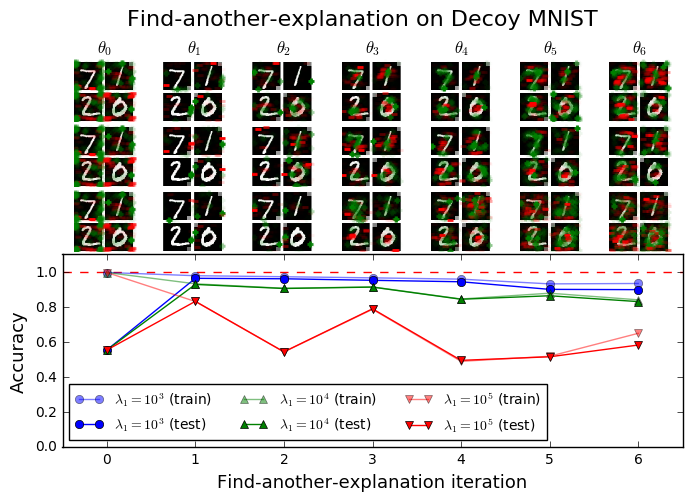

In [255]:
def explain2(model, title='', length=2, i=0, Xt=Xt, **kwargs):
  if title:
    plt.title(title)
  kwargs['size'] = 25
  kwargs['pwr'] = 3
  explanation_grid(model.grad_explain(Xt[i:i+length*length]), (28,28), gridshape=(length,length), **kwargs)

fig = plt.figure(figsize=(8,5))
plt.suptitle('Find-another-explanation on Decoy MNIST', y=1.0, fontsize=16)
gridsize = (6,7)
example = 0

for i in range(7):
  plt.subplot2grid(gridsize, (0,i))
  explain2(fae_1000s[i], r'$\theta_{}$'.format(i), i=example)
  
for i in range(7):
  plt.subplot2grid(gridsize, (1,i))
  explain2(fae_10000s[i], '',  i=example)
  
for i in range(7):
  plt.subplot2grid(gridsize, (2,i))
  explain2(fae_100000s[i], '', i=example)

plt.subplot2grid(gridsize, (3,0), rowspan=3, colspan=7)
plt.axhline(1, color='red', ls='--')
plt.plot(  list(range(len(fae_1000s))),   trn1000s, marker='o', label=r'$\lambda_1=10^3$ (train)', alpha=0.5, c='blue')
plt.plot(  list(range(len(fae_1000s))),   tst1000s, marker='o', label=r'$\lambda_1=10^3$ (test)', c='blue')
plt.plot( list(range(len(fae_10000s))),  trn10000s, marker='^', label=r'$\lambda_1=10^4$ (train)', alpha=0.5, c='green')
plt.plot( list(range(len(fae_10000s))),  tst10000s, marker='^', label=r'$\lambda_1=10^4$ (test)', c='green')
plt.plot(list(range(len(fae_100000s))), trn100000s, marker='v', label=r'$\lambda_1=10^5$ (train)', c='red', alpha=0.5)
plt.plot(list(range(len(fae_100000s))), tst100000s, marker='v', label=r'$\lambda_1=10^5$ (test)', c='red')
plt.legend(loc='best', fontsize=10, ncol=3)
plt.xlim(-0.5, 6.5)
plt.ylim(0.0, 1.1)
plt.xlabel(r'Find-another-explanation iteration', fontsize=13)
plt.ylabel('Accuracy', fontsize=13)  
fig.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

We can see that test accuracy increases after the first iteration, then slowly trends downward, possibly because we are biasing the model against considering the most significant elements of each image. For high $\lambda_1$, this happens much more abruptly, and even after just one iteration accuracy isn't quite back to ideal, perhaps because the original model did still consider some important components.

## Investigating cutoffs

Let's also just interrogate our arbitrary choice of cutoff slightly:

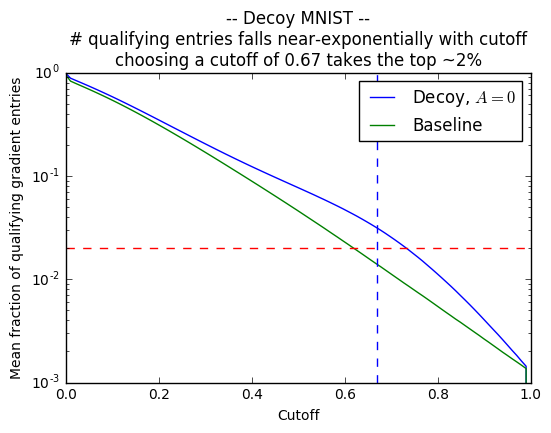

In [29]:
def M(input_gradients, cutoff=0.67):
  return np.array([np.abs(e) > cutoff*np.abs(e).max() for e in input_gradients]).astype(int).ravel()

grads = mlp_normal.input_gradients(Xt)

cutoffs = np.linspace(0,1,100)
cutoff_pcts = np.array([M(grads, c).sum() / float(len(grads.ravel())) for c in cutoffs])

grads2 = mlp_nondecoy.input_gradients(Xtr)
cutoff_pcts2 = np.array([M(grads2, c).sum() / float(len(grads2.ravel())) for c in cutoffs])

plt.plot(cutoffs, cutoff_pcts, label='Decoy, $A=0$')
plt.plot(cutoffs, cutoff_pcts2, label='Baseline')
plt.legend(loc='best')
plt.xlabel('Cutoff')
plt.ylabel('Mean fraction of qualifying gradient entries')
plt.yticks(np.linspace(0,1,21))
plt.axhline(0.02, ls='--', c='red')
plt.axvline(0.67, ls='--', c='blue')
plt.yscale('log')
plt.title('-- Decoy MNIST --\n# qualifying entries falls near-exponentially with cutoff\nchoosing a cutoff of 0.67 takes the top ~2%')
plt.show()

Here there does appear to be a bit of a kink in the curve at least for the decoy model, and it's about at where we chose our cutoff.

## Selecting $\lambda_1$

Let's do some brief cross-validation (running the models in a separate script). We can examine the change in train, validation (a subsplit the full training set), and test accuracy as we vary $\lambda_1$. Note that unlike in normal cross-validation, we want to explicitly assume that our training and validation sets are distributed differently than our test set. This suggests we should increase $\lambda_1$ further than necessary; if our accuracy on the training set decreases significantly it's too high, but at the point of maximum validation accuracy it might be too low.

In [52]:
# Parsing some copy-pasted print output to obtain cost function term ratios; forgive the sloppiness. 
import re
rr_prop = lambda _, xe, rr, __: float(rr) / float(xe)
rr_props = [rr_prop(*re.findall(r'[\d\.]+', blob.split("\n")[1]))
            for blob in open('../data/decoy_mnist_crossval_props.txt', 'r').read().split('############\n')[1:]]

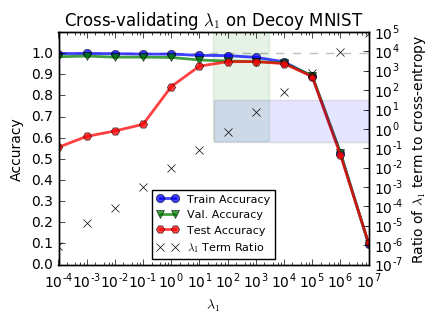

In [241]:
import pickle

l2s, accurs, params = pickle.load(open('../data/decoy_mnist_crossval.pkl', 'rb'))
accurs = np.array(accurs)[:-1]
trn, val, tst = accurs.T
l2s = l2s[:-1]

plt.figure(figsize=(4,3))

plt.axhline(1, ls='--', color='black', alpha=0.25)
plt.xscale('log')
plt.xlabel('$\lambda_1$')
plt.ylabel('Accuracy')
plt.title('Cross-validating $\lambda_1$ on Decoy MNIST')
plt.ylim(0, 1.1)
plt.yticks(np.linspace(0,1,11))

line1 = plt.plot(l2s, trn, label='Train Accuracy', marker='o', lw=2, alpha=0.75)
line2 = plt.plot(l2s, val, label='Val. Accuracy', marker='v', lw=2, alpha=0.75)
line3 = plt.plot(l2s, tst, label='Test Accuracy', marker='H', lw=2, alpha=0.75)
plt.axvspan(3e1, 3e3, ymin=0.53, alpha=0.1, color='green')

plt.gca().twinx()
plt.yscale('log')
plt.ylabel('Ratio of $\lambda_1$ term to cross-entropy')

line4 = plt.plot(l2s, rr_props[:-1], 'x', color='black', label='$\lambda_1$ Term Ratio')
plt.axhspan(2e-1, 3e1, xmin=0.5, alpha=0.1)

lines = line1+line2+line3+line4
labels = [l.get_label() for l in lines]
plt.legend(lines, labels, loc='lower center', fontsize=8)

plt.show()

As expected, we obtain the best test accuracy after our validation accuracy has actually started to decrease (because we've moved away from the easier decoy rule).

Interestingly, the "sweet spot" where we obtain high training, validation, and test accuracy corresponds to the region where the ratio of the "right answers" and "right reasons" terms in the loss function (near the start of the optimization) is close to 1. This makes intuitive sense; if we want to discourage the model from reaching a loss function minimum corresponding to the wrong reasons, then the $\lambda_1$ term has to be large, but it can't be so big that it completely overshadowns the cross-entropy.

Also note that a fairly wide range of $\lambda_1$s work for this problem; after test accuracy rises to baseline, we have about four orders of magnitude of wiggle room before all accuracies plummet to 0.1 (which corresponds to random guessing on this 10-class problem).